<a href="https://colab.research.google.com/github/janchorowski/dl_uwr/blob/summer2020/Assignment1/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

## Important notes
**Submission deadline:**
* **Thursday, 12.03.2020**

**Points: 13 + 2bp**

This assignment is meant to test your skills in course pre-requisites:  Scientific Python programming and  Machine Learning. If it is hard, I strongly advise you to drop the course.

Please use GitHub’s [pull requests](https://help.github.com/en/github/collaborating-with-issues-and-pull-requests/about-pull-requests) and issues to send corrections!

You can solve the assignment in any system you like, but we encourage you to try out [Google Colab](https://colab.research.google.com/).

## Assignment text
1. **[1p]** Download data competition from a Kaggle competition on sentiment prediction from [[https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data)].  Keep only full sentences, i.e. for each `SenteceId` keep only the entry with the lowest `PhraseId`.  Use first 7000 sentences as a `train set` and the remaining 1529 sentences as the `test set`. 

2. **[1p]** Prepare the data for logistic regression:
	Map the sentiment scores $0,1,2,3,4$ to a probability of the sentence being by setting $p(\textrm{positive}) = \textrm{sentiment}/4$.
	Build a dictionary of at most 20000 most frequent words.

3. **[3p]** Treat each document as a bag of words. e.g. if the vocabulary is 
	```
	0: the
	1: good
	2: movie
	3: is
	4: not
	5: a
	6: funny
	```
	Then the encodings can be:
	```
	good:                           [0,1,0,0,0,0,0]
	not good:                       [0,1,0,0,1,0,0] 
	the movie is not a funny movie: [1,0,2,1,1,1,1]
	```
    Train a logistic regression model to predict the sentiment. Compute the correlation between the predicted probabilities and the sentiment. Record the most positive and negative words.
    Please note that in this model each word gets its sentiment parameter $S_w$ and the score for a sentence is 
    $$\text{score}(\text{sentence}) = \sum_{w\text{ in sentence}}S_w$$

4. **[3p]** Now prepare an encoding in which negation flips the sign of the following words. For instance for our vocabulary the encodings become:
	```
	good:                           [0,1,0,0,0,0,0]
	not good:                       [0,-1,0,0,1,0,0]
	not not good:                   [0,1,0,0,0,0,0]
	the movie is not a funny movie: [1,0,0,1,1,-1,-1]
	```
	For best results, you will probably need to construct a list of negative words.
	
	Again train a logistic regression classifier and compare the results to the Bag of Words approach.
	
	Please note that this model still maintains a single parameter for each word, but now the sentence score is
	$$\text{score}(\text{sentence}) = \sum_{w\text{ in sentence}}-1^{\text{count of negations preceeding }w}S_w$$

5. **[5p]** Now also consider emphasizing words such as `very`. They can boost (multiply by a constant >1) the following words.
	Implement learning the modifying multiplier for negation and for emphasis. One way to do this is to introduce a model which has:
	- two modifiers, $N$ for negation and $E$ for emphasis
	- a sentiment score $S_w$ for each word 
And score each sentence as:
$$\text{score}(\text{sentence}) = \sum_{w\text{ in sentence}}N^{\text{\#negs prec. }w}E^{\text{\#emphs prec. }w}S_w$$

You will need to implement a custom logistic regression model to support it.

6. **[2pb]** Propose, implement, and evaluate an extension to the above model.


In [1]:
import pandas as pd
import numpy as np
from itertools import chain
from collections import Counter
import re

pattern = re.compile('[\W_]+')
first_data = pd.read_csv("train.tsv", delimiter='\t')
data=first_data.iloc[first_data.groupby('SentenceId')["PhraseId"].idxmin()]
data['Sentiment'] = data['Sentiment'].apply(lambda x: x / (4 + 0.00000001) + 0.000000001)
data["Phrase"] = data["Phrase"].apply(lambda x: x.lower().strip().split())
data.head()

/Users/michal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/michal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"[a, series, of, escapades, demonstrating, the,...",0.25
63,64,2,"[this, quiet, ,, introspective, and, entertain...",1.00
81,82,3,"[even, fans, of, ismail, merchant, 's, work, ,...",0.25
116,117,4,"[a, positively, thrilling, combination, of, et...",0.75
156,157,5,"[aggressive, self-glorification, and, a, manip...",0.25


In [2]:
word_frequency = dict(sorted(Counter(list(chain(*data['Phrase']))).items(), key=lambda x: -x[1]))
word_codes = dict(zip(word_frequency.keys(), range(len(word_frequency))))
rev_word_codes = {word_codes[k]: k for k in word_codes}

negative_words = [
"no",
"not",
"none",
"nobody",
"nothing",
"neither",
"nowhere",
"never",
"hardly",
"scarcely",
"barely",
"doesn’t",
"isn’t",
"wasn’t",
"shouldn’t",
"wouldn’t",
"couldn’t",
"won’t",
"can’t",
"don’t",
]
def word_embedding(sentence):
    vec = np.zeros(len(word_codes)).astype(int)
    for word in sentence:
        if word in word_codes:
            vec[word_codes[word]] += 1
    return vec

def word_embedding_with_negation(sentence):
    vec = np.zeros(len(word_codes)).astype(int)
    for word, previous_word in zip(sentence, ['none'] + sentence):
        if word in word_codes:
            if previous_word in negative_words:
                vec[word_codes[word]] -= 1
            else:
                vec[word_codes[word]] += 1
#             vec[word_codes[word]] += 1 if previous_word not in negative_words else -1
    return vec

In [3]:
data['codes'] = data['Phrase'].apply(word_embedding)
data['neg_codes'] = data['Phrase'].apply(word_embedding_with_negation)
data.head()

/Users/michal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/michal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,PhraseId,SentenceId,Phrase,Sentiment,codes,neg_codes
0,1,1,"[a, series, of, escapades, demonstrating, the,...",0.25,"[1, 3, 1, 2, 0, 4, 1, 2, 0, 0, 1, 0, 0, 1, 0, ...","[1, 3, 1, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 1, 0, ..."
63,64,2,"[this, quiet, ,, introspective, and, entertain...",1.00,"[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
81,82,3,"[even, fans, of, ismail, merchant, 's, work, ,...",0.25,"[1, 0, 2, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 2, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
116,117,4,"[a, positively, thrilling, combination, of, et...",0.75,"[1, 1, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
156,157,5,"[aggressive, self-glorification, and, a, manip...",0.25,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [52]:
%matplotlib inline
from sklearn.linear_model import LinearRegression, LogisticRegression
import itertools
import matplotlib.pyplot as plt

class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)
    
class LogisticProbRegression(LogisticRegression):
    targets = { x1: [0] * (4 - x1) + [1] * x1 for x1 in range(5)}
    def fit(self, x, p):
        X = np.repeat(x, repeats=4, axis=0)
        p = (p * 4.1).astype(int)
        y = np.array(list(itertools.chain.from_iterable([self.targets[_x] for _x in p])))
        return super().fit(X, y)


c2w = lambda x: [rev_word_codes[x2] for x2 in x]

    
def train(data, target, num_of_train, clf_class=LogitRegression):
    data = np.array(data.tolist())
    target = np.array(target)
    X = data[:num_of_train]
    y = target[:num_of_train]
    test_X = data[num_of_train:]
    test_y = target[num_of_train:]
    clf = clf_class()
    clf.fit(X, y)
    predicted = clf.predict(test_X)
    plt.scatter((test_y * 4.1).astype(int), predicted)

    pos = [np.mean(predicted[(test_y * 4.1).astype(int) == x]) for x in range(5)]
    plt.plot(range(5), pos, label='Avarage')
    plt.plot(range(5), np.arange(5.)/4, label='ideal')
    plt.legend()
    print(np.correlate(predicted, test_y))
    
    argsorted = np.argsort(clf.predict(np.eye(X.shape[1])))
    print('Negative:')
    print(c2w(list(argsorted[:50])))
    print("Positive:")
    print(c2w(list(argsorted[-50:])))

    return clf, test_X, test_y

[471.05318259]
Negative:
['disturb', 'waltz', 'stagey', 'disagree', 'scrutinize', 'doubting', 'hipness', 'toughest', 'conversion', 'hoult', 'shortest', 'promisingly', 'setpieces', 'gained', 'demonstrates', 'inspire', 'harm', 'oops', 'ripping', 'prettiest', 'dodge', 'reference', 'stinks', 'graceless', 'brings', 'monsterous', 'describes', 'broken', 'cynic', 'sacrifice', 'admiring', 'zip', 'distance', 'pushes', 'ignoring', 'repeating', 'battlefield', 'accurate', 'risks', 'rent', 'inhuman', 'downhill', 'open', 'joyless', 'releasing', 'x-men', 'direct', 'control-alt-delete', 'thousand', 'scuttled']
Positive:
['notable', 'evolving', 'actresses', 'interminably', 'crave', 'dog-paddle', 'convince', 'punch-drunk', 'mehta', 'snatch', 'righteousness', 'unpersuasive', 'wolfe', 'twenty-first', 'slightest', 'awfully', 'juxtapositions', 'genres', 'career-defining', 'orson', 'monotonous', 'evidence', 'brazenly', 'farts', 'happiness', 'conjured', 'whodunit', 'swimfan', 'humble', 'closure', 'remembrance'

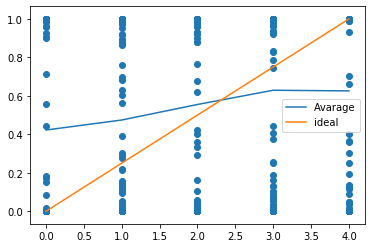

In [53]:
clf, test_X, test_y = train(data['codes'], data['Sentiment'], 7000)

/Users/michal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[533.99999947]
Negative:
['embarrassingly', 'amini', 'reconceptualize', 'cineasts', 'in-jokes', 'harvey', 'weinstein', 'bluff', 'rigors', 'denmark', 'dogma', 'splendour', 'k.', 'calculations', 'buying', 'refracting', 'hated', 'jaw-dropping', 'boffo', 'rough-hewn', 'andie', 'gamely', 'clean-cut', 'fiendish', 'hossein', 'schiffer', "c'mon", 'undertaken', 'lawmen', 'punchlines', 'fudged', 'gigantic', 'lunar', 'imbue', 'ramble', 'beresford', 'smarter-than-thou', 'propriety-obsessed', 'societal', 'psychologizing', 'galled', 'patriotic', 'strategic', 'dramatizing', 'define', 'straddle', 'graze', 'consciously', 'folktales', 'twinkly-eyed']
Positive:
['lift', 'kick', 'neighborhood', 'gut', 'melancholia', 'arliss', 'stanzas', 'orbit', '3-d', 'kev', 'jarring', 'ravishing', 'motorized', 'die-hard', 'and\\/or', 'hard-hearted', 'ignored', 'columbine', 'grungy', 'bravura', 'teasing', 'adage', 'dewy-eyed', 'unsolved', 'pearce', 'crowd-pleasing', 'estrogen-free', 'spotlights', 'charged', 'vulakoro', '

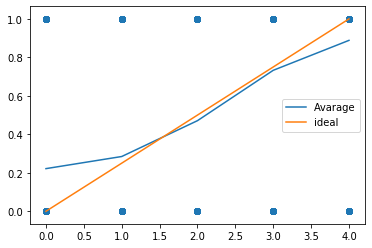

In [54]:
clf, test_X, test_y = train(data['codes'], data['Sentiment'], 7000, LogisticProbRegression)

[430.62820175]
Negative:
['school-age', 'allowed', 'talky', 'operative', 'tunney', 'alienating', 'choose', 'solaris', 'macabre', 'enjoys', 'fast', 'caught', 'modernized', 'tonto', 'expects', 'image', 'games', 'fervid', 'dupe', 'chimps', 'saved', 'tongue', 'relate', 'flatter', 'introduction', 'intellectually', 'pissed', 'decides', 'absorb', 'answering', 'producing', 'sanitised', 'releasing', 'improvised', 'diminishing', 'siuation', '1989', 'tunisian', 'lousy', 'started', 'fail', 'pray', 'freaky', 'ah-nuld', 'frantic', 'eastwood', 'pierce', 'unless', 'purr', "'til"]
Positive:
['catharsis', 'wishful', 'patriot', 'plodding', 'aside', 'idiotic', 'skill', 'establishes', 'scratches', 'double-cross', 'offended', 'itch', 'infused', 'protagonist', 'beat', 'action\\/comedy', 'canvas', 'resolved', 'inspires', 'blandly', 'delivered', 'comment', 'frothy', 'notice', 'drawers', 'andrei', 'twisted', 'codes', 'maguire', 'off-kilter', 'accident-prone', 'superb', 'achieves', 'stainton', 'grinning', 'publi

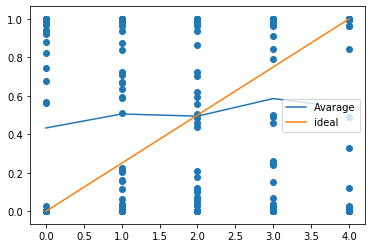

In [55]:
clf, test_X, test_y = train(data['neg_codes'], data['Sentiment'], 7000)

/Users/michal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[512.24999951]
Negative:
['.', 'techno-tripe', 'calculus', 'm.i.t.', 'equations', 'long-winded', 'discoveries', 'not-at-all-good', 'jostling', 'elbowed', 'rotoscope', 'christine', 'sylvie', 'icily', 'prehistoric', 'reverberates', 'dispel', 'stodgy', 'teleprompter', 'anton', 'ick', 'despairingly', 'infuriatingly', 'rash', 'day-old', 'location', 'bender', 'single-minded', 'tequila', 'burrito', 'origin', 'road-and-buddy', 'all-inclusive', 'uptight', 'bores', 'literarily', 'description', 'high-powered', 'fetid', 'uglier', 'kuras', 'cross-cultural', 'swathe', 'retaining', 'refusing', 'painkillers', 'anti-human', 'miles', 'graceland', 'thirty-three']
Positive:
['1957', 'reflected', 'exploits', 'hack-and-slash', 'recognizably', 'freedom', 'trims', 'tortured', 'immediate', 'oddity', 'anthony', 'lured', 'indieflick', 'glorious', 'revelation', 'william', 'masterly', 'mountain', 'aliens', 'sport', 'jessica', 'held', 'upper', 'pleaser', 'faked', 'streamlined', 'spain', 'amicable', 'ado', 'tactics'

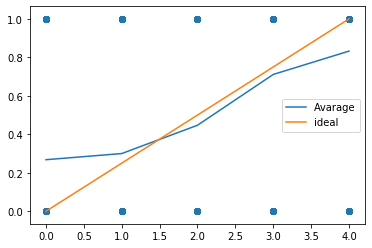

In [56]:
clf, test_X, test_y = train(data['neg_codes'], data['Sentiment'], 7000, LogisticProbRegression)